# Time Series Analysis with Pastas
    
*Developed by Mark Bakker, TU Delft*

Required files to run this notebook (all available from the `data` subdirectory):

* Head files: `head_nb1.csv`, `B58C0698001_1.csv`, `B50H0026001_1.csv`, `B22C0090001_1.csv`, `headwell.csv`
* Pricipitation files: `rain_nb1.csv`, `neerslaggeg_HEIBLOEM-L_967.txt`, `neerslaggeg_ESBEEK_831.txt`, `neerslaggeg_VILSTEREN_342.txt`, `rainwell.csv`
* Evaporation files: `evap_nb1.csv`, `etmgeg_380.txt`, `etmgeg_260.txt`, `evapwell.csv`
* Well files: `well1.csv`, `well2.csv`
* Figure: `b58c0698_dino.png`

### Pastas
Pastas is a computer program for hydrological time series analysis and is available from the [Pastas Github](https://github.com/pastas/pastas) . Pastas makes heavy use of `pandas` `timeseries`. An introduction to `pandas` `timeseries` can be found, for example, [here](http://nbviewer.jupyter.org/github/mbakker7/exploratory_computing_with_python/blob/master/notebook8_pandas/py_exploratory_comp_8_sol.ipynb). The Pastas documentation is available [here](http://pastas.readthedocs.io).

In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.21.2
Scipy version: 1.7.1
Pandas version: 1.3.3
Pastas version: 0.19.0b
Matplotlib version: 3.4.3


### Load the head observations
The first step in time series analysis is to load a time series of head observations. The time series needs to be stored as a `pandas.Series` object where the index is the date (and time, if desired). `pandas` provides many options to load time series data, depending on the format of the file that contains the time series. In this example, measured heads are stored in the csv file `head_nb1.csv`. 
The heads are read from a csv file with the `read_csv` function of `pandas` and are then squeezed to create a `pandas Series` object.  To check if you have the correct data type, use the `type` command as shown below. 

In [2]:
ho = pd.read_csv('../data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
print('The data type of the oseries is:', type(ho))

The data type of the oseries is: <class 'pandas.core.series.Series'>


The variable `ho` is now a `pandas Series` object. To see the first five lines, type `ho.head()`. 

In [3]:
ho.head()

date
1985-11-14    27.61
1985-11-28    27.73
1985-12-14    27.91
1985-12-28    28.13
1986-01-13    28.32
Name: head, dtype: float64

The series can be plotted as follows

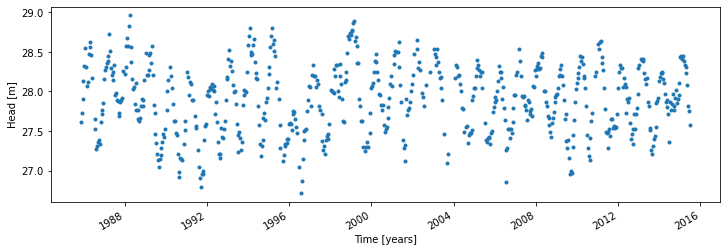

In [4]:
ho.plot(style='.', figsize=(12, 4))
plt.ylabel('Head [m]');
plt.xlabel('Time [years]');

### Load the stresses
The head variation shown above is believed to be caused by two stresses: rainfall and evaporation. Measured rainfall is stored in the file `rain_nb1.csv` and measured potential evaporation is stored in the file `evap_nb1.csv`. 
The rainfall and potential evaporation are loaded and plotted.

The data type of the rain series is: <class 'pandas.core.series.Series'>
The data type of the evap series is <class 'pandas.core.series.Series'>


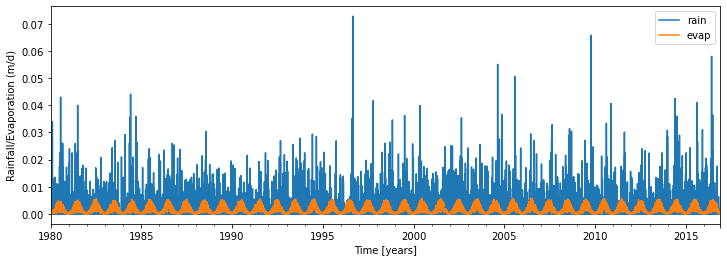

In [5]:
rain = pd.read_csv('../data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
print('The data type of the rain series is:', type(rain))

evap = pd.read_csv('../data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
print('The data type of the evap series is', type(evap))

plt.figure(figsize=(12, 4))
rain.plot(label='rain')
evap.plot(label='evap')
plt.xlabel('Time [years]')
plt.ylabel('Rainfall/Evaporation (m/d)')
plt.legend(loc='best');

### Recharge
As a first simple model, the recharge is approximated as the measured rainfall minus the measured potential evaporation.

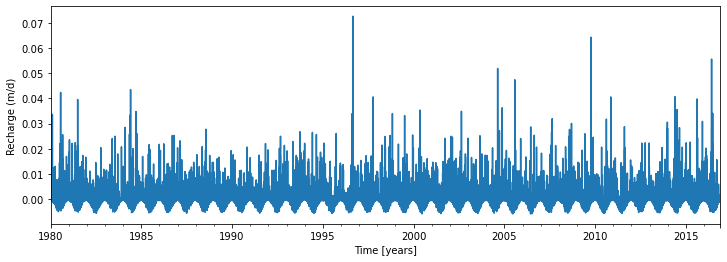

In [6]:
recharge = rain - evap
plt.figure(figsize=(12, 4))
recharge.plot()
plt.xlabel('Time [years]')
plt.ylabel('Recharge (m/d)');

### First time series model
Once the time series are read from the data files, a time series model can be constructed by going through the following three steps:

1. Creat a `Model` object by passing it the observed head series. Store your model in a variable so that you can use it later on. 
2. Add the stresses that are expected to cause the observed head variation to the model. In this example, this is only the recharge series. For each stess, a `StressModel` object needs to be created. Each `StressModel` object needs three input arguments: the time series of the stress, the response function that is used to simulate the effect of the stress, and a name. In addition, it is recommended to specified the `kind` of series, which is used to perform a number of checks on the series and fix problems when needed. This checking and fixing of problems (for example, what to substitute for a missing value) depends on the kind of series. In this case, the time series of the stress is stored in the variable `recharge`, the Gamma function is used to simulate the response, the series will be called `'recharge'`, and the kind is `prec` which stands for precipitation. One of the other keyword arguments of the `StressModel` class is `up`, which means that a positive stress results in an increase (up) of the head. The default value is `True`, which we use in this case as a positive recharge will result in the heads going up. Each `StressModel` object needs to be stored in a variable, after which it can be added to the model. 
3. When everything is added, the model can be solved. The default option is to minimize the sum of the squares of the errors between the observed and modeled heads. 

In [7]:
ml = ps.Model(ho)
sm1 = ps.StressModel(recharge, ps.Gamma, name='recharge', settings='prec')
ml.add_stressmodel(sm1)
ml.solve(tmin='1985', tmax='2010')

Fit report head                     Fit Statistics
nfev    10                     EVP           92.02
nobs    518                    R2             0.92
noise   True                   RMSE           0.13
tmin    1985-11-14 00:00:00    AIC        -2592.26
tmax    2010-01-01 00:00:00    BIC        -2571.01
freq    D                      Obj            1.70
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (5 optimized)
                optimal   stderr     initial  vary
recharge_A   749.010453   ±4.79%  215.674528  True
recharge_n     1.049137   ±1.53%    1.000000  True
recharge_a   134.483793   ±6.73%   10.000000  True
constant_d    27.547665   ±0.07%   27.900078  True
noise_alpha   58.973443  ±12.37%   15.000000  True


The `solve` function has a number of default options that can be specified with keyword arguments. One of these options is that by default a fit report is printed to the screen. The fit report includes a summary of the fitting procedure, the optimal values obtained by the fitting routine, and some basic statistics. The model contains five parameters: the parameters $A$, $n$, and $a$ of the Gamma function used as the response function for the recharge, the parameter $d$, which is a constant base level, and the parameter $\alpha$ of the noise model, which will be explained a little later on in this notebook.
The results of the model are plotted below.

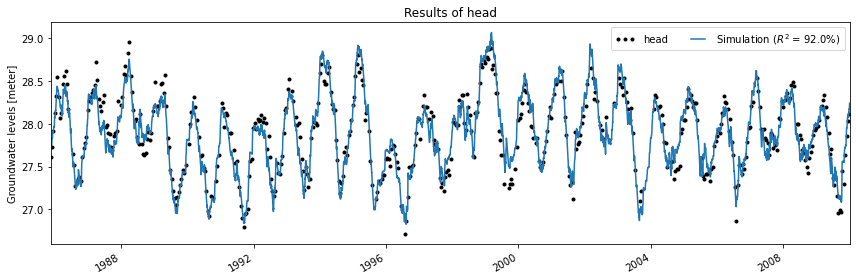

In [8]:
ml.plot(figsize=(12, 4));

In [9]:
ml = ps.Model(ho)
sm1 = ps.StressModel(recharge, ps.Gamma, name='recharge', settings='prec')
ml.add_stressmodel(sm1)
ml.solve(tmin='1985', tmax='2010', solver=ps.LeastSquares)

Fit report head                     Fit Statistics
nfev    10                     EVP           92.02
nobs    518                    R2             0.92
noise   True                   RMSE           0.13
tmin    1985-11-14 00:00:00    AIC        -2592.26
tmax    2010-01-01 00:00:00    BIC        -2571.01
freq    D                      Obj            1.70
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (5 optimized)
                optimal   stderr     initial  vary
recharge_A   749.010453   ±4.79%  215.674528  True
recharge_n     1.049137   ±1.53%    1.000000  True
recharge_a   134.483793   ±6.73%   10.000000  True
constant_d    27.547665   ±0.07%   27.900078  True
noise_alpha   58.973443  ±12.37%   15.000000  True


In [10]:
ml = ps.Model(ho)
sm1 = ps.StressModel(recharge, ps.Gamma, name='recharge', settings='prec')
ml.add_stressmodel(sm1)
ml.set_parameter('recharge_n', vary=False)
ml.solve(tmin='1985', tmax='2010', solver=ps.LeastSquares)

Fit report head                      Fit Statistics
nfev    23                     EVP           91.52
nobs    518                    R2             0.92
noise   True                   RMSE           0.13
tmin    1985-11-14 00:00:00    AIC        -2584.62
tmax    2010-01-01 00:00:00    BIC        -2567.62
freq    D                      Obj            1.74
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (4 optimized)
                optimal   stderr     initial   vary
recharge_A   776.738694   ±5.08%  215.674528   True
recharge_n     1.000000    ±nan%    1.000000  False
recharge_a   153.740242   ±5.46%   10.000000   True
constant_d    27.534802   ±0.08%   27.900078   True
noise_alpha   64.122503  ±12.81%   15.000000   True


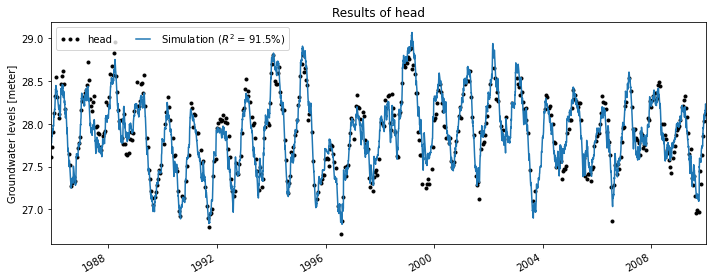

In [11]:
ml.plot(figsize=(10, 4));